# Bluecoats Phase 1: Program Evaluation - Project Selection
### Budgeting exercise and selection behavior
#### Question: Is the budgeting exercise an effective and well-recieved method of selecting projects and, if so, do clear and dominant choices emerge?
* Yes, this exercise was simple to execute and effective in identifying projects to begin developing.



* Budgeting exercise allowing team-driven selection of local issues to resolve

In [1]:
# Modules
from bluecoats_p1_config import *

import pandas as pd
import numpy as np
from scipy import stats

import re
import copy
import math
import random
import datetime
from collections import defaultdict

import glob
import os

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns; 
sns.set()

%matplotlib inline

# Pandas view options
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)
pd.set_option('display.precision', 4)

# Jupyter display options
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:95% !important; }</style>"))

# Program Parameters

## Constants

# Read Data

In [3]:
budget = pd.read_csv(RAW_DATA_PATH + 'bc_budgeting_final_20221031.csv', header=None)
budget_headers = budget.iloc[:2].copy()
budget_data = budget.iloc[3:].copy().reset_index(drop=True)

In [4]:
# Clean headers
q_ids = budget_headers.iloc[0].str.lower().str.strip().str.replace('_1','',1).to_list()[2:]
q_labels_long = budget_headers.iloc[1].str.lower().str.strip().to_list()[2:]
q_labels_short = ['crossrole_comradery','human_needs','positive_outcomes','emotional_support','prof_development',
                  'waiting_room','crossunit_efficiency','other','other_content','additional_notes','name','role']

q_dict_long = dict(zip(q_ids,q_labels_long))
q_dict_short = dict(zip(q_ids,q_labels_short))
use_cols = ['start_date','end_date'] + [idx+'_'+label for idx,label in zip(q_ids,q_labels_short)]
budget_data.columns = use_cols

# Clean columns
date_cols = budget_data.columns[:2]
num_cols = budget_data.columns[2:10]
str_cols = budget_data.columns[10:]

fill_dict = {col:0 for col in num_cols}
fill_dict.update({col:'' for col in str_cols})
budget_data = budget_data.fillna(fill_dict)

budget_data.loc[:,date_cols] = budget_data[date_cols].apply(pd.to_datetime)
type_dict = {col:'float' for col in num_cols}
type_dict.update({col:'str' for col in str_cols})
budget_data = budget_data.astype(type_dict)

In [47]:
print(len(budget_data))
print(len(budget_data.columns))
budget_data.head()

128
14


,start_date,end_date,q1_1_crossrole_comradery,q1_2_human_needs,q1_3_positive_outcomes,q1_4_emotional_support,q1_5_prof_development,q1_6_waiting_room,q1_7_crossunit_efficiency,q1_8_other,q2_other_content,q3_additional_notes,q4_name,q5_role
0,2022-10-05 11:33:00,2022-10-05 11:34:00,0.0,50.0,0.0,0.0,10.0,0.0,0.0,40.0,"Financial recognition, retention bonuses, tuit...",,,
1,2022-10-05 11:34:00,2022-10-05 11:35:00,10.0,10.0,10.0,10.0,50.0,5.0,5.0,0.0,,,,
2,2022-10-05 11:35:00,2022-10-05 11:35:00,0.0,20.0,0.0,30.0,0.0,30.0,20.0,0.0,,,,
3,2022-10-05 11:36:00,2022-10-05 11:37:00,10.0,10.0,10.0,20.0,10.0,5.0,5.0,30.0,being able to come together and shift in and o...,,,
4,2022-10-05 11:37:00,2022-10-05 11:38:00,10.0,20.0,50.0,10.0,10.0,0.0,0.0,0.0,,,,


# Data Analysis

In [21]:
print((budget_data['end_date'] - budget_data['start_date']).mean())
print((budget_data['end_date'] - budget_data['start_date']).median())

0 days 00:01:16.875000
0 days 00:01:00


In [53]:
NUM_RESP = 128
use_cols = ['total_alloc','mean_alloc','median_alloc','std_dev_alloc','num_nonzero_alloc','pct_nonzero_alloc',
            'mean_nonzero_alloc','median_nonzero_alloc','std_dev_nonzero_alloc']
budget_summary = pd.concat([budget_data[num_cols].sum(),
                            budget_data[num_cols].mean(),
                            budget_data[num_cols].median(),
                            budget_data[num_cols].std(),
                            budget_data[budget_data[num_cols]!= 0][num_cols].count(),
                            budget_data[budget_data[num_cols]!= 0][num_cols].count()/NUM_RESP,
                            budget_data[budget_data[num_cols]!= 0][num_cols].mean(),
                            budget_data[budget_data[num_cols]!= 0][num_cols].median(),
                            budget_data[budget_data[num_cols]!= 0][num_cols].std()],axis=1)
budget_summary.columns = use_cols
budget_summary

,total_alloc,mean_alloc,median_alloc,std_dev_alloc,num_nonzero_alloc,pct_nonzero_alloc,mean_nonzero_alloc,median_nonzero_alloc,std_dev_nonzero_alloc
q1_1_crossrole_comradery,1762.5,13.7695,10.0,17.1169,72,0.5625,24.4792,20.0,16.0693
q1_2_human_needs,3423.0,26.7422,22.5,25.1062,99,0.7734,34.5758,30.0,23.3072
q1_3_positive_outcomes,1231.0,9.6172,0.0,13.1963,62,0.4844,19.8548,20.0,12.4885
q1_4_emotional_support,916.0,7.1562,0.0,10.6848,54,0.4219,16.9630,15.0,10.2017
q1_5_prof_development,1389.0,10.8516,4.5,14.1800,66,0.5156,21.0455,20.0,13.2298
q1_6_waiting_room,1331.0,10.3984,4.0,13.7075,66,0.5156,20.1667,20.0,12.9265
q1_7_crossunit_efficiency,1407.5,10.9961,5.0,13.7544,71,0.5547,19.8239,20.0,12.8736
q1_8_other,1240.0,9.6875,0.0,23.1288,28,0.2188,44.2857,30.0,30.4508


In [63]:
# Mean number of categories awarded points by each respondent
budget_data[budget_data[num_cols]!= 0][num_cols].count(axis=1).mean()

4.046875

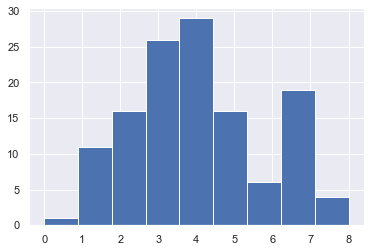

In [62]:
# Historgram of number of categories awarded points by each respondent
budget_data[budget_data[num_cols]!= 0][num_cols].count(axis=1).hist(bins=9)

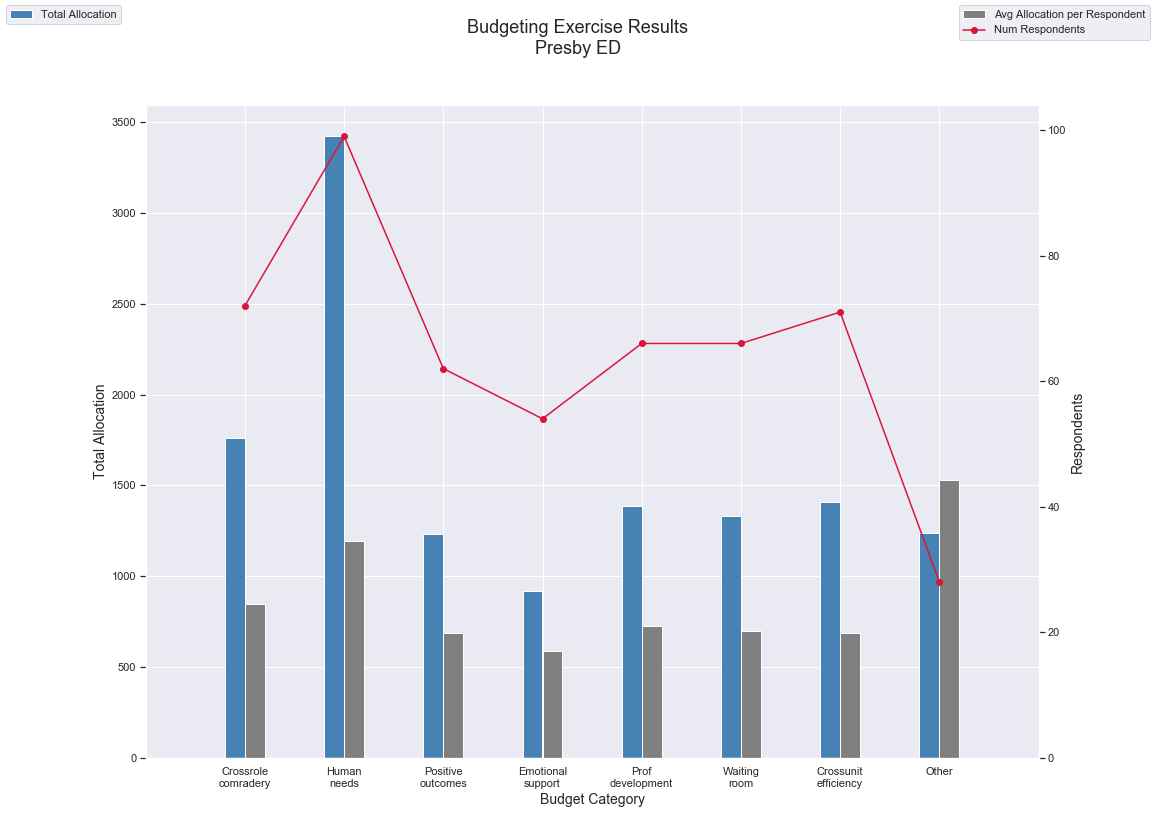

In [190]:
fig, ax = plt.subplots(figsize=(16,12))
ax_twin = ax.twinx()
xlabels = ['\n'.join(item.split('_')[2:]).capitalize() for item in num_cols]
width=0.2

data = budget_summary.copy()
total_plot = data['total_alloc'].plot(kind='bar', ax=ax, grid=True, color='steelblue', width=width, position=1)
mean_plot = data['mean_nonzero_alloc'].plot(kind='bar', ax=ax_twin, grid=False, color='grey', width=width, position=0)
resp_plot= data['num_nonzero_alloc'].plot(ax=ax_twin, grid=False, marker='o', color='crimson',)
# IDEA: try line plot for avg. alloc with marker size for num respondents to avoid needing three y-axes/labels
# can add special marker/label text for largest avg. alloc / capita and largest total, respectively
# this is the way

fig.suptitle('Budgeting Exercise Results\nPresby ED', fontsize=18)

ax.set_xlim(-1,len(num_cols))
ax.set_xlabel('Budget Category', fontsize=14)
ax.set_xticklabels(xlabels,rotation=0)

ax.set_ylabel('Total Allocation', fontsize=14)
ax_twin.set_ylabel('Respondents', fontsize=14)

# Legend
ax_handles = ax.get_legend_handles_labels()[0]
ax_labels = ax.get_legend_handles_labels()[1]
ax_twin_handles = ax_twin.get_legend_handles_labels()[0][::-1]
ax_twin_labels = ax_twin.get_legend_handles_labels()[1][::-1]
handles = ax_handles + ax_twin_handles
labels = ax_labels + ax_twin_labels
fig.legend(handles=handles[0],labels=['Total Allocation'],loc='upper left')
fig.legend(handles=handles[1:],labels=['Avg Allocation per Respondent','Num Respondents'],loc='upper right')

In [192]:
q_labels_long

['build comradery across roles in the ed (ensure work of each role is valued',
 'basic human needs',
 'communicate more of the positive outcomes in the ed, not just the number of patients seen (might look like: positive feedback from patients, inpatient teams sharing news about ed patients post ed discharge',
 'create space to honor the emotional impact of working in the ed (might look like: emotional debriefs, access to individualized mental health resources, venting rounds',
 'create opportunities for mentoring & skills building within and across roles (might look like: clinical debriefs, de-escalation training, ultrasound certifications)',
 'decrease stress in the waiting room (might look like: designated seating areas for different patient types, patient/family support services)',
 'improve the working relationship between the ed and inpatient units (might look like: transport, tools for doc to doc communication, presby wide charge nurse gathering)',
 'something else',
 'if you awa

# Unused / Deprecated Code

In [ ]:
"""
# For counting nonzero column values
budget_data[num_cols].astype(bool).sum(axis=0)

"""